<h1> <center> DiffraPy - Homogeneous Velocity Model Example </h1> </center>

******************

Guilherme Zakarewicz¹, Susanne Maciel¹

¹University of Brasília (UnB)

2023

******************

This is an interactive Jupyter Notebook with an example of a homogeneous velocity model. Here, we show how to use the main functions of ``DiffraPy``.

### Table of contents <a class='anchor' id='top'></a>

- [1 - Creating the model](#chapter1)
- [2 - Traveltime table](#chapter2)
- [3 - Wavelet](#chapter3)
- [4 - Forward modeling synthetic seismic gathers](#chapter4)
- [5 - Calculating the reflector dip field](#chapter5)
- [6 - Migration](#chapter6)

### Importing libs and modules

The main libraries ([numpy](https://numpy.org/), [scipy](https://scipy.org/), [matpotlib](https://matplotlib.org/), [importlib](https://docs.python.org/3/library/importlib.html)) can be easily installed with <b> pip </b>.

In [4]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import Diffrapy as df

## 1 - Creating the model <a class="anchor" id="chapter1"></a>

Model's parameters

In [5]:
nx=150 #meters
nz=100 #meters
ntr=150 #number of traces in acquisition
dx=1.0 #meter
dz=1.0 #meter
c=250 #constant velocity [m/s]

Model's geometry

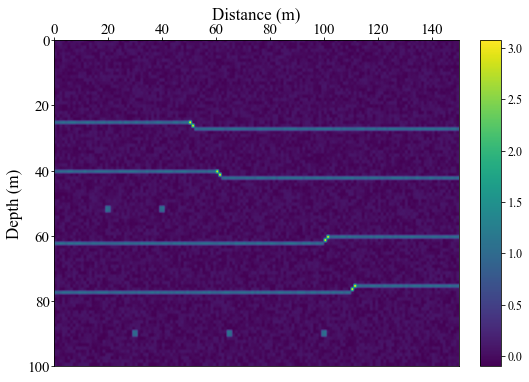

In [25]:
MOD = np.zeros([ntr,nz])

#####################################
for i in range(0,int(np.round(nx/3))):
    z1 = int(np.round(nz/4))
    MOD[i,z1]=1
    
for i in range(int(np.round((2+nx/3))),nx):
    z2 = int(np.round(nz/4 + 2))
    MOD[i,z2]=1

x1 = np.arange(np.round(nx/3),np.round(nx/3+2))
z1 = np.arange(np.round(nz/4),np.round(nz/4+2))

for i in range(len(x1)):
    for j in range(len(z1)):
        x=int(x1[i])
        z=int(z1[i])
        MOD[x,z]=3

#####################################
for i in range(0,int(np.round(10 + nx/3))):
    z1 = int(np.round(nz/4 + 15))
    MOD[i,z1]=1    

for i in range(int(np.round((12 + nx/3))),nx):
    z2 = int(np.round(nz/4 + 17))
    MOD[i,z2]=1
    
x2 = np.arange(np.round(10 + nx/3),np.round(12 + nx/3))
z2 = np.arange(np.round(nz/4 + 15),np.round(nz/4 + 17))

for i in range(len(x2)):
    for j in range(len(z2)):
        x=int(x2[i])
        z=int(z2[i])
        MOD[x,z]=3

#####################################
for i in range(int(np.round((2+2*nx/3))),nx):
    z1 = int(np.round(3*nz/5))
    MOD[i,z1]=1
    
for i in range(0,int(np.round(2*nx/3))):
    z2 = int(np.round(3*nz/5 + 2))
    MOD[i,z2]=1

x3 = np.arange(np.round(2*nx/3),np.round(2+2*nx/3))
z3 = np.arange(np.round(3*nz/5),np.round(3*nz/5 + 2))

for i in range(len(x3)):
    for j in range(len(z3)):
        x=int(x3[1-i])
        z=int(z3[i])
        MOD[x,z]=3
    
#####################################
for i in range(int(np.round((10+2+2*nx/3))),nx):
    z1 = int(np.round(15+3*nz/5))
    MOD[i,z1]=1
    
for i in range(0,int(np.round(10+2*nx/3))):
    z2 = int(np.round(3*nz/5 + 2 +15))
    MOD[i,z2]=1

x4 = np.arange(np.round(10+2*nx/3),np.round(10+2+2*nx/3))
z4 = np.arange(np.round(3*nz/5+15),np.round(3*nz/5 + 2 + 15))

for i in range(len(x4)):
    for j in range(len(z4)):
        x=int(x4[1-i])
        z=int(z4[i])
        MOD[x,z]=3
    
#####################################    
    
MOD[20-1:20+1,52-1:52+1]=1
MOD[40-1:40+1,52-1:52+1]=1

MOD[30-1:30+1,90-1:90+1]=1
MOD[65-1:65+1,90-1:90+1]=1
MOD[100-1:100+1,90-1:90+1]=1
    
# Adding noise to the model
nn = np.random.rand(nx,nz)
MOD = MOD+(nn-0.5)*0.2

R = MOD.T

df.plot(R,"homo_R",nx,dx,nz,dz,"Distance (m)","Depth (m)")

For simplicity, we define a vagarosity model (SW = 1/c)

In [7]:
SW=np.ones([nz,ntr])*1/c

***********

## 2 - Traveltime table <a class="anchor" id="chapter2"></a>

Creating the traveltime table based on the velocity model. We can save it as a binary file and open it later.

In [8]:
#After generating the traveltime table, you can comment the following command

#TT=MigPreFuncoes.raymodel3(SW,dx,ntr,"Data/TTh_100x150_250mps.npy")

Opening the binary file with the traveltime table

In [17]:
with open('Data/TTh_100x150_250mps.npy', 'rb') as f:
    TTh = np.load(f)

dt=0.004
timer=np.round(TTh/dt)+1

***********

## 3 - Wavelet <a class="anchor" id="chapter3"></a>

Creating a Ricker wavelet for generating the synthetic seismic data

In [18]:
#Wavelet

fr=40 #Hz
nps=200
dt=.004 #s
rick=df.ricker(nps,fr,dt)
tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1]

***********

## 4 - Forward modeling synthetic seismic gathers <a class="anchor" id="chapter4"></a>

In [19]:
dsx = 15 #Shots spacing
nsx = nx
ngx = nx
path = "Data/CSG_diffbar/dummy_teste"

In [20]:
#After generating the common shot gathers, you can comment the following command

#files = df.kirchhoffModeling(nsx,ngx,dsx,nx,nt,dt,TTh,R,W,path)

We store the gathers in the ``files`` np.ndarray

In [21]:
files = []

for i in range(0,nsx,dsx):
    filename = 'Data/CSG_diffbar/dummy_teste_{}'.format(i)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

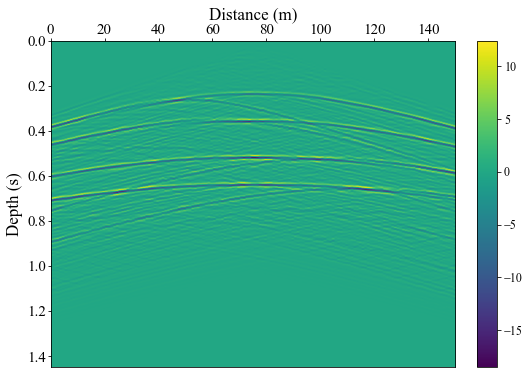

In [23]:
df.plot(files[5],"shot_75_homo",nx,dx,nt,dt,"Distance (m)","Depth (s)")

***********

## 5 - Calculating the reflector dip field <a class="anchor" id="chapter5"></a>

In [24]:
pmin = -1
pmax = 1
dp = 0.1
xwin=zwin=30
dx=dz=1
x_ini=z_ini=0

pm,sm = df.local_window(R,xwin,zwin,x_ini,z_ini,dx,dz,pmin,pmax,dp)

with open("Data/CSG_diffbar/Homogeneous_model_pm", "wb") as f: 
    np.save(f, pm)
    
with open("Data/CSG_diffbar/Homogeneous_model_semblance", "wb") as f: 
    np.save(f, sm)

with open("Data/CSG_diffbar/Homogeneous_model_pm", "rb") as f:
    pm = np.load(f)

with open("Data/CSG_diffbar/Homogeneous_model_semblance", "rb") as f:
    sm = np.load(f)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.75it/s]


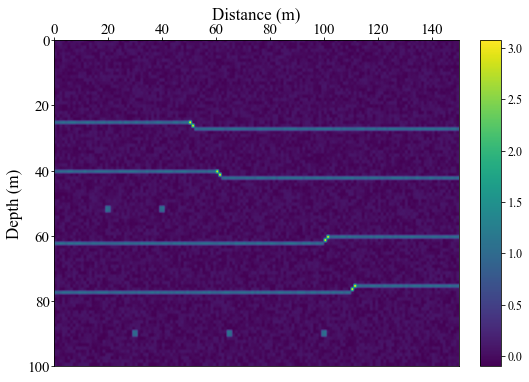

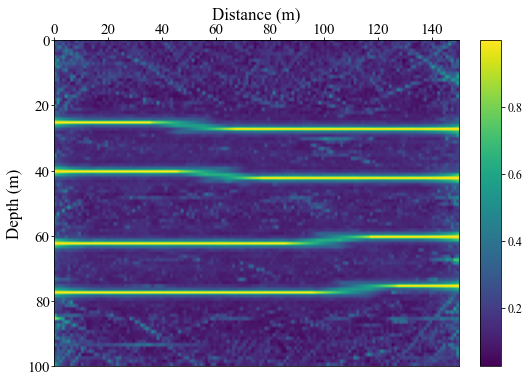

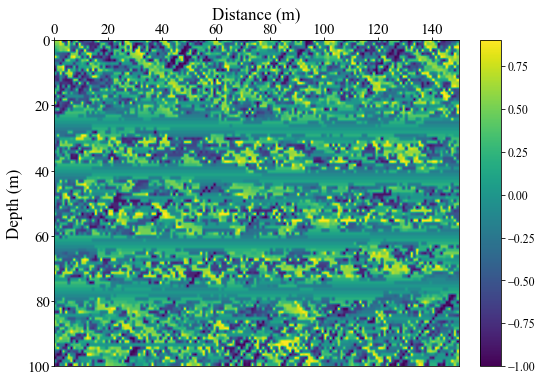

In [26]:
df.plot(R,"homo_R",nx,dx,nz,dz,"Distance (m)","Depth (m)")
df.plot(sm,"homo_sm",nx,dx,nz,dz,"Distance (m)","Depth (m)")
df.plot(pm,"homo_pm",nx,dx,nz,dz,"Distance (m)","Depth (m)")

After we calculated the dip field, it is possible to generate both horizontal and vertical components

In [27]:
m_theta = np.arctan(pm)
X = np.sin(m_theta)
Y = np.cos(m_theta)

***********

## 6 - Migration <a class="anchor" id="chapter6"></a>

Migration's parameters

In [28]:
dwin=dt
win=5*dt #Time Window
app_ref=20 #Aperture for conventional migration
app_dif=80 #Aperture for diffraction migration

gather1 = files[5] 
isx = 75

Migrating only one synthetic csg for tunning parameters 

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:13<00:00, 11.05it/s]


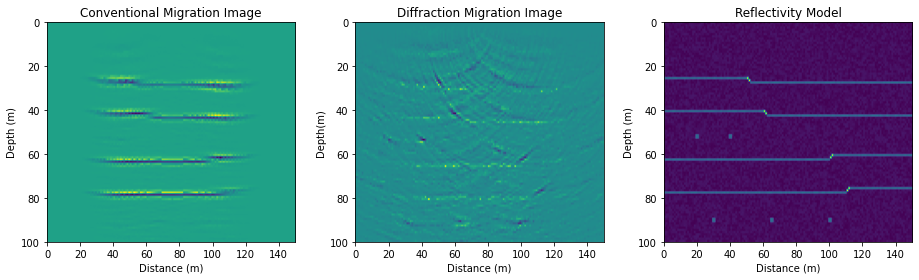

In [29]:
refl,diff = df.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm,SW)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Conventional Migration Image")
ax1.set_xlabel("Distance (m)")
ax1.set_ylabel("Depth (m)")

ax2.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Diffraction Migration Image")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Depth(m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Reflectivity Model")
ax3.set_xlabel("Distance (m)")
ax3.set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()

Migrating all the synthetic csg

10it [02:04, 12.45s/it]


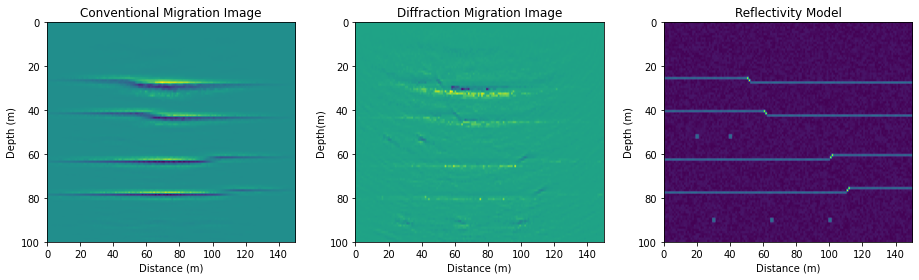

In [33]:
refls,diffs = df.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm,SW)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refls, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Conventional Migration Image")
ax1.set_xlabel("Distance (m)")
ax1.set_ylabel("Depth (m)")

ax2.imshow(diffs, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Diffraction Migration Image")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Depth(m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Reflectivity Model")
ax3.set_xlabel("Distance (m)")
ax3.set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()

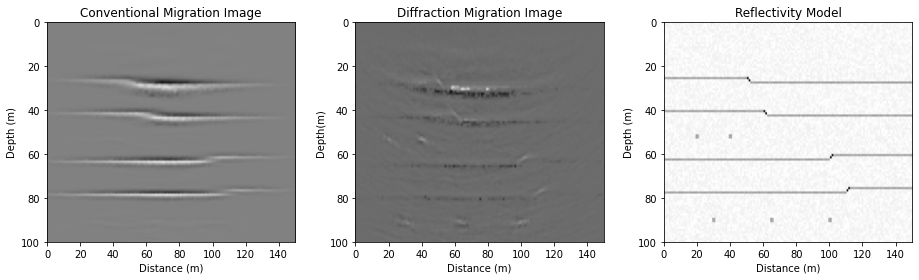

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

cm="binary"
it="gaussian"

ax1.imshow(refls, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax1.set_title("Conventional Migration Image")
ax1.set_xlabel("Distance (m)")
ax1.set_ylabel("Depth (m)")

ax2.imshow(diffs, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax2.set_title("Diffraction Migration Image")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Depth(m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm)
ax3.set_title("Reflectivity Model")
ax3.set_xlabel("Distance (m)")
ax3.set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()

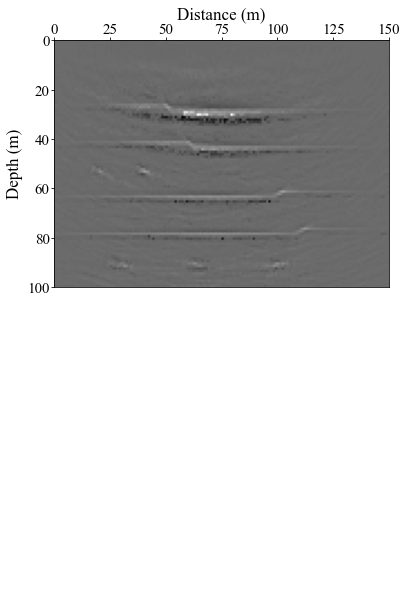

In [35]:
tm_summ = 4*diffs+refls

csfont = {'fontname':'Times New Roman'}

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,10))

im1 = ax1.imshow(tm_summ, extent=[0, nx*dx, nz*dz, 0], aspect='auto', cmap="binary", interpolation=None) #, extent=[0, nx*dx, nz*dz, 0]
ax1.set_ylabel("Depth (m)", **csfont, fontsize=17)
ax1.set_xlabel("Distance (m)", **csfont, fontsize=17)

ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.tick_params(axis='x', which='major', pad=0, labelsize=15)
ax1.tick_params(axis='y', which='major', pad=1, labelsize=15)

for tick in ax1.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Times New Roman")
    
ax2.set_axis_off()

plt.savefig("Data/tm_summ.png",dpi=300)
plt.show()

In [37]:
vel1_toohigh = np.ones([nz,ntr])*c*1.05
vel1_toolow = np.ones([nz,ntr])*c*0.95
SW_toohigh = 1./vel1_toohigh
SW_toolow = 1./vel1_toolow

In [38]:
#TT_toohigh = df.raymodel3(SW_toohigh,dx,ntr,"Data/CSG_diffbar/raiosHomo_toohigh.npy")
#TT_toolow = df.raymodel3(SW_toolow,dx,ntr,"Data/CSG_diffbar/raiosHomo_toolow.npy")

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [18:40<00:00,  7.47s/it]


In [51]:
with open('Data/TTh_100x150_250mps.npy', 'rb') as f:
    TTh = np.load(f)

dt=0.004
timer=np.round(TTh/dt)+1
    
with open("Data/CSG_diffbar/raiosHomo_toohigh.npy", 'rb') as f:
    TTh_toohigh = np.load(f)
    
with open("Data/CSG_diffbar/raiosHomo_toolow.npy", 'rb') as f:
    TTh_toolow = np.load(f)

timer=np.round(TTh/dt)+1
timer_toohigh=np.round(TTh_toohigh/dt)+1
timer_toolow=np.round(TTh_toolow/dt)+1

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:10<00:00, 14.11it/s]


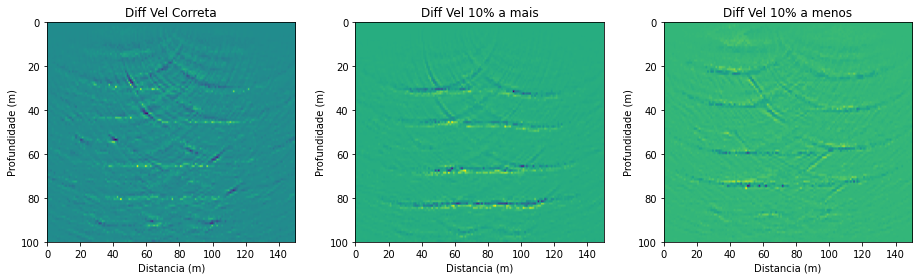

In [52]:
refl,diff = df.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm,SW)
refl_toohigh,diff_toohigh = df.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh_toohigh,X,Y,sm,SW)
refl_toolow,diff_toolow = df.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh_toolow,X,Y,sm,SW)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Diff Vel Correta")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_toohigh, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Diff Vel 10% a mais")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(diff_toolow, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Diff Vel 10% a menos")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

10it [01:26,  8.68s/it]
10it [01:28,  8.83s/it]
10it [01:48, 10.89s/it]


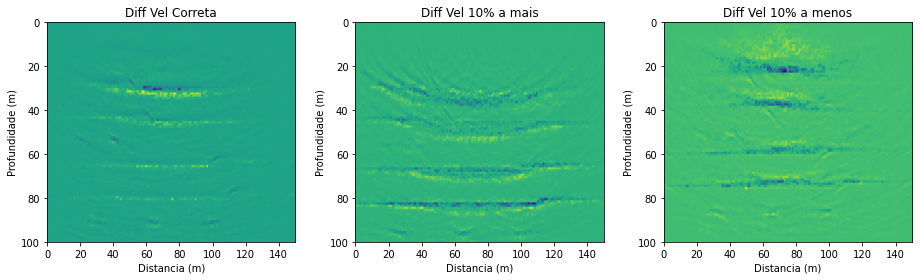

In [53]:
refl,diff = df.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm,SW)
refl_toohigh,diff_toohigh = df.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh_toohigh,X,Y,sm,SW)
refl_toolow,diff_toolow = df.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh_toolow,X,Y,sm,SW)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Diff Vel Correta")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_toohigh, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Diff Vel 10% a mais")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(diff_toolow, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Diff Vel 10% a menos")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

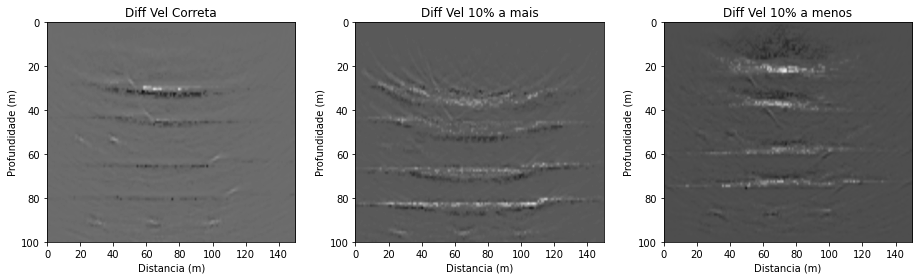

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax1.set_title("Diff Vel Correta")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_toohigh, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax2.set_title("Diff Vel 10% a mais")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(diff_toolow, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax3.set_title("Diff Vel 10% a menos")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

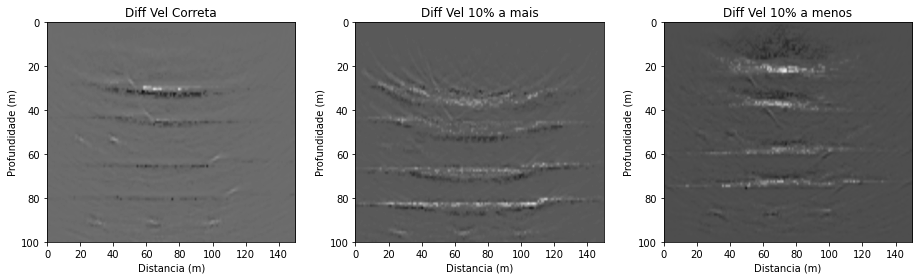

In [67]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax1.set_title("Diff Vel Correta")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_toohigh, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax2.set_title("Diff Vel 10% a mais")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(diff_toolow, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap=cm,interpolation=it)
ax3.set_title("Diff Vel 10% a menos")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

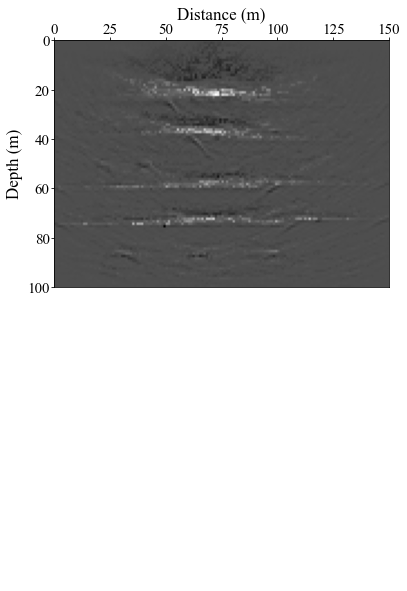

In [70]:
csfont = {'fontname':'Times New Roman'}

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,10))

im1 = ax1.imshow(diff_toolow, extent=[0, nx*dx, nz*dz, 0], aspect='auto', cmap="binary", interpolation=None)
ax1.set_ylabel("Depth (m)", **csfont, fontsize=17)
ax1.set_xlabel("Distance (m)", **csfont, fontsize=17)

ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.tick_params(axis='x', which='major', pad=0, labelsize=15)
ax1.tick_params(axis='y', which='major', pad=1, labelsize=15)

for tick in ax1.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Times New Roman")
    
ax2.set_axis_off()

plt.savefig("Data/homo_diff_toolow.png",dpi=300)
plt.show()